# Drone Anomaly Detection Dataset

AAI-530 Group 2 Final Project

| Group Members |
|:---|
| Aliaksei Matsarski |
| Andrew Fennimore |

This notebook downloads the Drone Anomaly Detection Time Series Dataset from Kaggle, loads and inspects the data, runs some exploratory data analysis, and then splits it into train, validation, and test sets for modeling.

## Dataset Description

This dataset contains preprocessed time series data for a binary classification task. The goal is to determine whether a drone is healthy or faulty based on its motion data. The data has already been windowed with no missing values.

### Source

The data is derived from the "DronePropA: Motion Trajectories Dataset for Defective Drones" by Ismail, Elshaar, et al. The original dataset consists of 130 .mat files, each representing a single flight experiment. You can find the processed version on [Kaggle](https://www.kaggle.com/datasets/PirMustafa/drone-dataset).

### Preprocessing

The original .mat files were processed into a single .npz file. The following steps were applied (Information taken from the [Kaggle dataset page](https://www.kaggle.com/datasets/PirMustafa/drone-dataset)):

1. Feature Extraction: For each of the 130 flights, 12 specific time series features were extracted focusing on the drone's core motion dynamics.
2. Labeling: Each flight was labeled as healthy or faulty based on the file naming convention described in the source paper. Healthy is 0 and faulty is 1.
3. Windowing: The time series data from each flight was segmented into overlapping windows. Each window is 200 timesteps long with a 50% overlap between consecutive windows.
4. Aggregation: All windows from all flights were stacked into a single dataset.

### Structure

The data is contained in a single compressed NumPy archive file called processed_data.npz, which is around 637 MB. This file contains two arrays, X and y.

X is a 3 dimensional NumPy array containing the feature data:
- The first dimension is the total number of windows aggregated from all flights
- The second dimension is the number of timesteps in each window, which is 200
- The third dimension is the number of features recorded at each timestep, which is 12

y is a 1 dimensional NumPy array containing the corresponding labels for each window in X. A value of 0 means the window came from a healthy flight, and a value of 1 means it came from a faulty flight.

### Features

The 12 features in the third dimension of X are, in order:

1. Position X in meters
2. Position Y in meters
3. Position Z in meters
4. Roll in radians
5. Pitch in radians
6. Yaw in radians
7. Roll Rate in rad/s
8. Pitch Rate in rad/s
9. Yaw Rate in rad/s
10. Acceleration X in m/s squared
11. Acceleration Y in m/s squared
12. Acceleration Z in m/s squared

## 1. Prerequisites

Before running this notebook, make sure you have the following set up:

1. A Kaggle account (you can sign up at [kaggle.com](https://www.kaggle.com))
2. Install the required packages by running `pip install -r requirements.txt`
3. The first time you run this, `kagglehub` will ask you to log in through your browser. After that it remembers your credentials so you won't need to do it again.

In [3]:
import kagglehub
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf

In [4]:
# grab the dataset from kaggle, it will cache locally so it only downloads once
dataset_path = kagglehub.dataset_download("PirMustafa/drone-dataset")
print(f"Dataset downloaded to: {dataset_path}")

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 608M/608M [00:15<00:00, 40.1MB/s]

Extracting files...


Dataset downloaded to: /Users/amatsarski/.cache/kagglehub/datasets/PirMustafa/drone-dataset/versions/1


## 2. Load and Inspect the Data

Now that the dataset is downloaded, we can load the `.npz` file and take a look at what is inside.

In [5]:
# load up the npz file
NPZ_FILE = os.path.join(dataset_path, "processed_data.npz")
data = np.load(NPZ_FILE)

# see what arrays are in here
print("Arrays in the .npz file:", list(data.keys()))

# pull out features and labels
X = data["X"]
y = data["y"]

print(f"\nFeatures X shape: {X.shape}")
print(f"  - {X.shape[0]} windows")
print(f"  - {X.shape[1]} timesteps per window")
print(f"  - {X.shape[2]} features per timestep")

print(f"\nLabels y shape: {y.shape}")
print(f"  - Unique labels: {np.unique(y)}")
print(f"  - Label distribution: 0 = healthy = {np.sum(y == 0)}, 1 = faulty = {np.sum(y == 1)}")

print(f"\nX dtype: {X.dtype}")
print(f"y dtype: {y.dtype}")

# check for missing values
nan_count = np.isnan(X).sum()
print(f"\nMissing values in X: {nan_count}")

# check for duplicate windows by flattening each window and comparing
X_2d = X.reshape(X.shape[0], -1)
n_duplicates = X_2d.shape[0] - np.unique(X_2d, axis = 0).shape[0]
print(f"Duplicate windows: {n_duplicates}")

# check labels for anything unexpected
print(f"\nUnique labels in y: {np.unique(y)}")
print(f"Missing values in y: {np.isnan(y.astype(float)).sum()}")

Arrays in the .npz file: ['X', 'y']

Features X shape: (100389, 200, 12)
  - 100389 windows
  - 200 timesteps per window
  - 12 features per timestep

Labels y shape: (100389,)
  - Unique labels: [0 1]
  - Label distribution: 0 = healthy = 30792, 1 = faulty = 69597

X dtype: float64
y dtype: int64

Missing values in X: 0
Duplicate windows: 0

Unique labels in y: [0 1]
Missing values in y: 0


## 3. Display First Windows as DataFrames

Since `X` is a 3D array (windows x timesteps x features), each "row" is really a full window of 200 timesteps across 12 features. To get a better look at the actual values, we will convert the first two windows into pandas DataFrames with named columns and show the first and last few timesteps of each.

In [6]:
# the 12 feature names in order
FEATURE_NAMES = [
    "Position_X", "Position_Y", "Position_Z",
    "Roll", "Pitch", "Yaw",
    "Roll_Rate", "Pitch_Rate", "Yaw_Rate",
    "Acceleration_X", "Acceleration_Y", "Acceleration_Z"
]

# show the first 2 windows as dataframes so we can eyeball the values
for i in range(2):
    window = X[i]  # 200 timesteps x 12 features
    df = pd.DataFrame(window, columns = FEATURE_NAMES)
    df.index.name = "Timestep"

    label_str = "Healthy" if y[i] == 0 else "Faulty"

    print(f"\n{"=" * 80}")
    print(f"Window {i} | Label: {y[i]} - {label_str}")
    print(f"{"=" * 80}")

    display(df.head(5))
    print(f"  ... {len(df) - 10} rows omitted ...")
    display(df.tail(5))


Window 0 | Label: 0 - Healthy


,Position_X,Position_Y,Position_Z,Roll,Pitch,Yaw,Roll_Rate,Pitch_Rate,Yaw_Rate,Acceleration_X,Acceleration_Y,Acceleration_Z
Timestep,,,,,,,,,,,,
0,0.0,0.0,0.0,0.000000,0.000000,0.000000,-0.025966,0.039015,-0.195210,-0.067038,-0.124498,9.950302
1,0.0,0.0,0.0,-0.000029,0.000041,-0.000195,-0.025966,0.039015,-0.195210,-0.057461,-0.114922,9.916783
2,0.0,0.0,0.0,-0.000023,0.000042,-0.000103,-0.025966,0.039015,-0.195210,-0.076614,-0.129287,9.926360
3,0.0,0.0,0.0,-0.000017,0.000043,-0.000011,-0.025458,0.038444,-0.191070,-0.076614,-0.129287,9.926360
4,0.0,0.0,0.0,-0.000011,0.000044,0.000082,-0.024563,0.037438,-0.183784,-0.086191,-0.095768,9.926360


  ... 190 rows omitted ...


,Position_X,Position_Y,Position_Z,Roll,Pitch,Yaw,Roll_Rate,Pitch_Rate,Yaw_Rate,Acceleration_X,Acceleration_Y,Acceleration_Z
Timestep,,,,,,,,,,,,
195,0.017636,-0.017215,0.006119,-0.000897,0.002682,0.006360,-0.001659,0.012070,0.033556,-0.071826,-0.110133,9.911995
196,0.017636,-0.017215,0.006119,-0.000902,0.002694,0.006394,-0.001696,0.012045,0.033571,-0.090980,-0.138864,9.916783
197,0.017636,-0.017215,0.006119,-0.000907,0.002706,0.006426,-0.001729,0.012011,0.033576,-0.076614,-0.129287,9.945514
198,0.017636,-0.017215,0.006119,-0.000912,0.002719,0.006459,-0.001760,0.011970,0.033569,-0.076614,-0.110133,9.935937
199,0.017636,-0.017215,0.006119,-0.000917,0.002732,0.006492,-0.001789,0.011934,0.033552,-0.081403,-0.114922,9.911995



Window 1 | Label: 0 - Healthy


,Position_X,Position_Y,Position_Z,Roll,Pitch,Yaw,Roll_Rate,Pitch_Rate,Yaw_Rate,Acceleration_X,Acceleration_Y,Acceleration_Z
Timestep,,,,,,,,,,,,
0,0.017636,-0.017199,0.006117,-0.000467,0.001380,0.003185,-0.001707,0.012396,0.033005,-0.090980,-0.114922,9.916783
1,0.017636,-0.017199,0.006117,-0.000473,0.001394,0.003219,-0.001756,0.012395,0.033032,-0.057461,-0.095768,9.921572
2,0.017636,-0.017199,0.006117,-0.000479,0.001408,0.003253,-0.001819,0.012392,0.033061,-0.057461,-0.110133,9.916783
3,0.017636,-0.017199,0.006117,-0.000484,0.001422,0.003286,-0.001885,0.012395,0.033094,-0.081403,-0.119710,9.935937
4,0.017636,-0.017199,0.006117,-0.000490,0.001436,0.003321,-0.001954,0.012403,0.033127,-0.067038,-0.114922,9.926360


  ... 190 rows omitted ...


,Position_X,Position_Y,Position_Z,Roll,Pitch,Yaw,Roll_Rate,Pitch_Rate,Yaw_Rate,Acceleration_X,Acceleration_Y,Acceleration_Z
Timestep,,,,,,,,,,,,
195,0.017640,-0.017222,0.006108,-0.001320,0.003991,0.009665,-0.001605,0.012072,0.033409,-0.067038,-0.086191,9.911995
196,0.017639,-0.017214,0.006102,-0.001325,0.004004,0.009699,-0.001628,0.012078,0.033433,-0.067038,-0.119710,9.907206
197,0.017639,-0.017214,0.006102,-0.001330,0.004017,0.009732,-0.001651,0.012079,0.033456,-0.081403,-0.090980,9.926360
198,0.017639,-0.017214,0.006102,-0.001334,0.004030,0.009765,-0.001673,0.012084,0.033469,-0.086191,-0.110133,9.916783
199,0.017639,-0.017214,0.006102,-0.001339,0.004044,0.009798,-0.001696,0.012092,0.033475,-0.086191,-0.110133,9.926360


## 4. Basic Summary Statistics

Here we run some quick sanity checks on the feature ranges and look at how the labels are distributed across the dataset.

In [7]:
# flatten X down to 2D so we can run describe across all timesteps
X_flat = X.reshape(-1, X.shape[2])
stats_df = pd.DataFrame(X_flat, columns = FEATURE_NAMES).describe()

# format the table so it doesnt show scientific notation
print("Overall feature statistics across all windows and timesteps:")
display(stats_df.style.format("{:.4f}"))

# check the label balance
total = len(y)
healthy = np.sum(y == 0)
faulty = np.sum(y == 1)

print(f"\nLabel balance:")
print(f"  Healthy: {healthy} - {100 * healthy / total:.1f}%")
print(f"  Faulty:  {faulty} - {100 * faulty / total:.1f}%")

Overall feature statistics across all windows and timesteps:


,Position_X,Position_Y,Position_Z,Roll,Pitch,Yaw,Roll_Rate,Pitch_Rate,Yaw_Rate,Acceleration_X,Acceleration_Y,Acceleration_Z
count,20077800.0000,20077800.0000,20077800.0000,20077800.0000,20077800.0000,20077800.0000,20077800.0000,20077800.0000,20077800.0000,20077800.0000,20077800.0000,20077800.0000
mean,-0.0995,-0.0571,0.5451,-0.0134,-0.0021,1.3265,-0.0017,0.0119,0.0321,0.0366,-0.1310,9.8894
std,0.4862,0.4859,0.2906,0.0211,0.0235,0.8666,0.0925,0.1053,0.1121,2.7865,2.2994,4.4859
min,-1.0458,-1.0783,0.0000,-0.3410,-0.2343,-0.0838,-4.3633,-2.3573,-4.3633,-78.4388,-47.3429,-152.5394
25%,-0.0845,-0.0497,0.2391,-0.0178,-0.0102,0.5776,-0.0195,-0.0126,0.0265,-1.7238,-1.5993,7.1395
50%,-0.0040,-0.0077,0.7454,-0.0137,-0.0039,1.2550,-0.0015,0.0120,0.0330,-0.0287,-0.1149,9.9216
75%,0.0207,0.0185,0.7537,-0.0092,0.0048,1.9854,0.0163,0.0364,0.0381,1.7813,1.3695,12.6941
max,1.0742,1.0982,0.8592,0.1919,0.2182,3.5942,2.0307,4.3633,1.8400,67.0424,27.2077,156.9016



Label balance:
  Healthy: 30792 - 30.7%
  Faulty:  69597 - 69.3%


## 5. Exploratory Data Analysis

In this section we visualize the class balance, look at how the 12 features are distributed across healthy and faulty windows, and plot a sample window from each class to see what the raw time series data looks like.

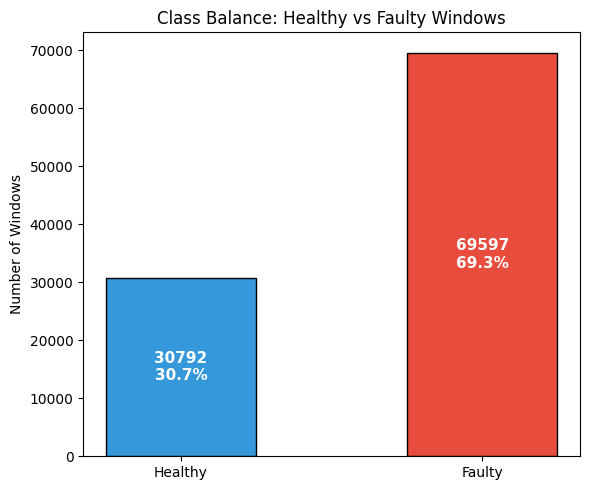

In [8]:
# bar chart for class balance
labels, counts = np.unique(y, return_counts = True)
label_names = ["Healthy", "Faulty"]
colors = ["#3498db", "#e74c3c"]

fig, ax = plt.subplots(figsize = (6, 5))
bars = ax.bar(label_names, counts, color = colors, edgecolor = "black", width = 0.5)

for bar, count in zip(bars, counts):
    pct = 100 * count / len(y)
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() / 2,
        f"{count}\n{pct:.1f}%",
        ha = "center", va = "center", fontweight = "bold", fontsize = 11, color = "white"
    )

ax.set_ylabel("Number of Windows")
ax.set_title("Class Balance: Healthy vs Faulty Windows")
plt.tight_layout()
plt.show()

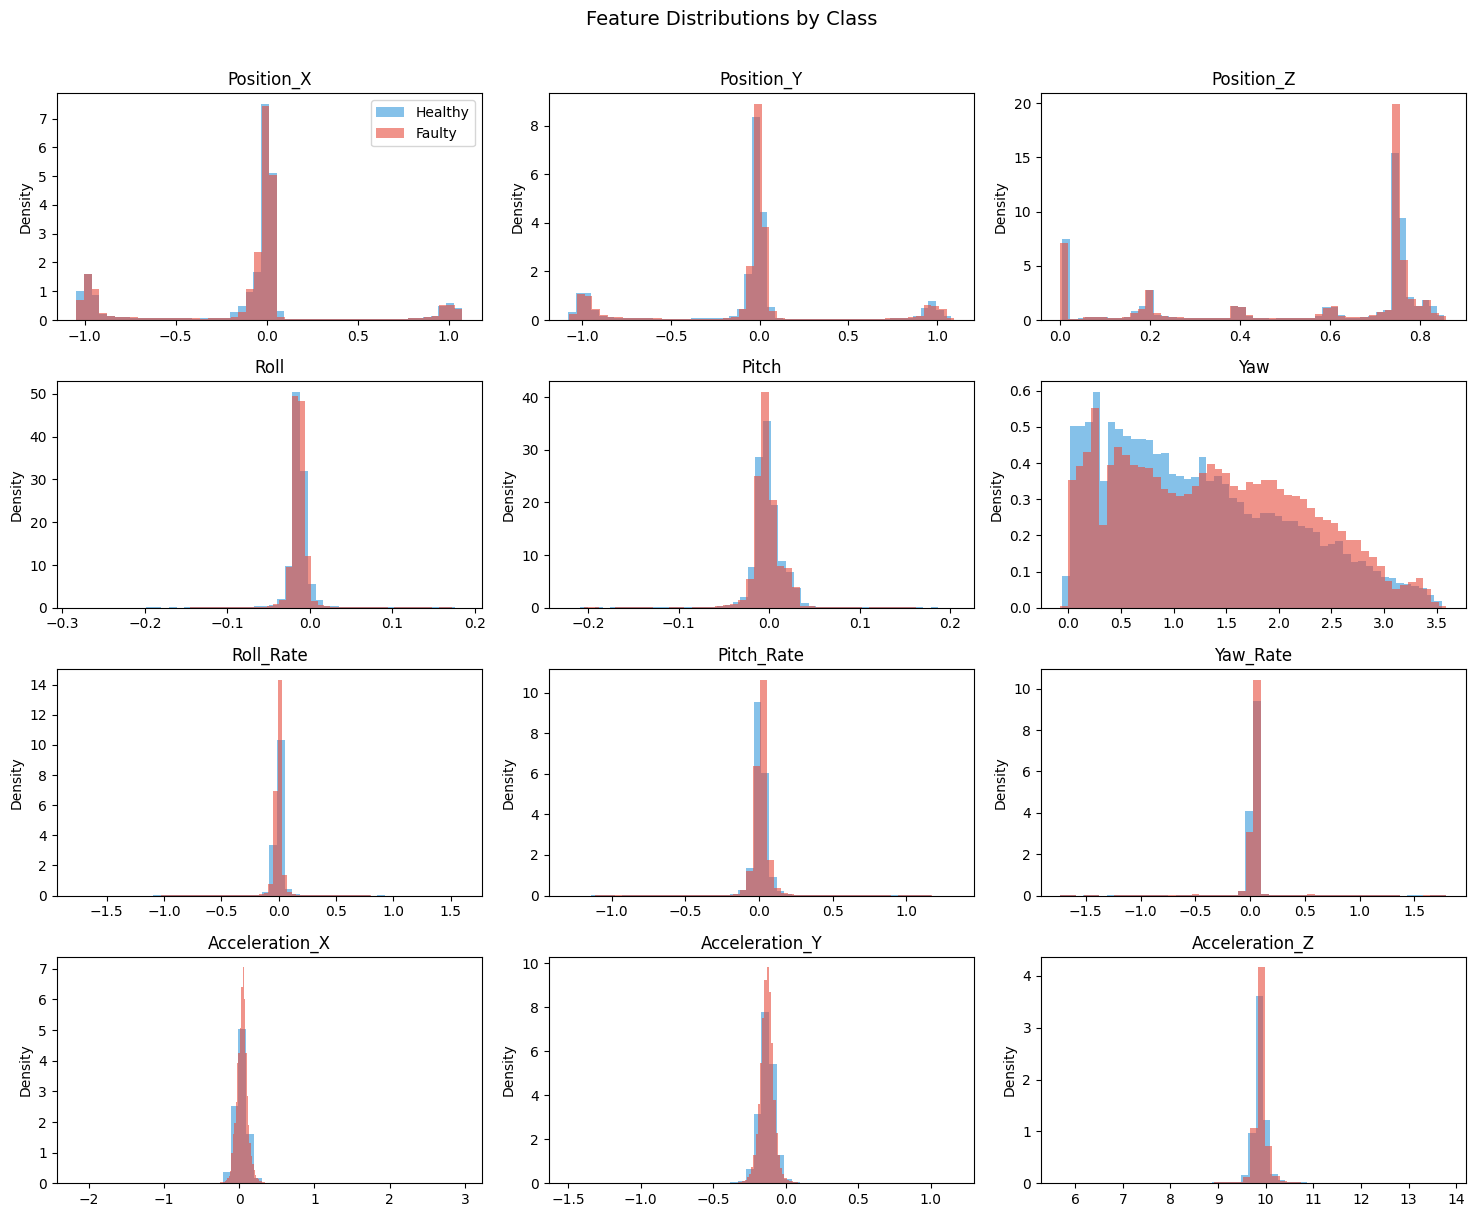

In [9]:
# feature distributions using the per-window mean, split by class
X_mean = X.mean(axis = 1)  # average each window down to 12 values

fig, axes = plt.subplots(4, 3, figsize = (15, 12))
axes = axes.flatten()

for i, (ax, name) in enumerate(zip(axes, FEATURE_NAMES)):
    ax.hist(X_mean[y == 0, i], bins = 50, alpha = 0.6, color = "#3498db", label = "Healthy", density = True)
    ax.hist(X_mean[y == 1, i], bins = 50, alpha = 0.6, color = "#e74c3c", label = "Faulty", density = True)
    ax.set_title(name)
    ax.set_ylabel("Density")

    if i == 0:
        ax.legend()

fig.suptitle("Feature Distributions by Class", fontsize = 14, y = 1.01)
plt.tight_layout()
plt.show()

## 6. Train / Validation / Test Split

We split the data into 70% training, 15% validation, and 15% test sets using stratified sampling so the class balance stays consistent across all three sets. Since the dataset comes pre windowed and we do not have flight IDs, we cannot do a per flight split, so a stratified random split is the best we can do here.

In [10]:
# first split: 70% train, 30% temp
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size = 0.30, random_state = 1, stratify = y
)

# second split: chop the 30% in half for 15% val and 15% test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size = 0.50, random_state = 1, stratify = y_temp
)

# print out shapes and class balance for each split
for name, X_split, y_split in [("Train", X_train, y_train),
                                ("Validation", X_val, y_val),
                                ("Test", X_test, y_test)]:
    n = len(y_split)
    h = np.sum(y_split == 0)
    f = np.sum(y_split == 1)

    print(f"{name:>10s}: X = {X_split.shape}, y = {y_split.shape}  |  "
          f"Healthy = {h} - {100 * h / n:.1f}%  Faulty = {f} - {100 * f / n:.1f}%")

print(f"\n  Total: {len(y_train)} + {len(y_val)} + {len(y_test)} = {len(y_train) + len(y_val) + len(y_test)}")

     Train: X = (70272, 200, 12), y = (70272,)  |  Healthy = 21554 - 30.7%  Faulty = 48718 - 69.3%
Validation: X = (15058, 200, 12), y = (15058,)  |  Healthy = 4619 - 30.7%  Faulty = 10439 - 69.3%
      Test: X = (15059, 200, 12), y = (15059,)  |  Healthy = 4619 - 30.7%  Faulty = 10440 - 69.3%

  Total: 70272 + 15058 + 15059 = 100389


### Export Splits

We save each split as a `.npz` file in the `data/` directory so they are easy to load later during model training.

In [11]:
# save each split to the data folder as npz files
DATA_DIR = os.path.join(os.getcwd(), "data")
os.makedirs(DATA_DIR, exist_ok = True)

np.savez(os.path.join(DATA_DIR, "train.npz"), X = X_train, y = y_train)
np.savez(os.path.join(DATA_DIR, "validation.npz"), X = X_val, y = y_val)
np.savez(os.path.join(DATA_DIR, "test.npz"), X = X_test, y = y_test)

print("Saved to data/:")

for name in ["train.npz", "validation.npz", "test.npz"]:
    d = np.load(os.path.join(DATA_DIR, name))
    print(f"  {name}: X = {d['X'].shape}, y = {d['y'].shape}")

Saved to data/:
  train.npz: X = (70272, 200, 12), y = (70272,)
  validation.npz: X = (15058, 200, 12), y = (15058,)
  test.npz: X = (15059, 200, 12), y = (15059,)


## 7. LSTM Model

Now we can build and train an LSTM to classify each window as healthy or faulty. The model takes in the full sequence of 200 timesteps across all 12 features and learns to pick up on patterns that separate the two classes. We wrap everything in a class so its easy to train and make predictions with.

In [12]:
class LSTM:
    def __init__(self, num_units, n_classes, n_input,
                 time_steps, learning_rate = 0.001):
        self.steps = time_steps
        self.n = n_input

        # build the lstm model
        self.model = tf.keras.Sequential([
            tf.keras.layers.LSTM(num_units, input_shape = (time_steps, n_input)),
            tf.keras.layers.Dense(n_classes, activation = "softmax")
        ])

        # compile with adam optimizer and cross entropy loss
        self.model.compile(
            optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate),
            loss = "sparse_categorical_crossentropy",
            metrics = ["accuracy"]
        )

    def train(self, X, Y, epochs = 100, batch_size = 128):
        # reshape input to match what the lstm expects
        X = X.reshape((len(X), self.steps, self.n))

        # train the model
        self.history = self.model.fit(X, Y, epochs = epochs, batch_size = batch_size)

    def predict(self, X):
        # predicting the output
        test_data = X.reshape((-1, self.steps, self.n))
        out = self.model.predict(test_data)
        return out

In [13]:
# load the split data from the saved npz files
DATA_DIR = os.path.join(os.getcwd(), "data")
train_data = np.load(os.path.join(DATA_DIR, "train.npz"))
val_data = np.load(os.path.join(DATA_DIR, "validation.npz"))
test_data = np.load(os.path.join(DATA_DIR, "test.npz"))

X_train, y_train = train_data["X"], train_data["y"]
X_val, y_val = val_data["X"], val_data["y"]
X_test, y_test = test_data["X"], test_data["y"]

# create the lstm model
# 128 hidden units, 2 classes, 12 features, 200 timesteps
model = LSTM(
    num_units = 128,
    n_classes = 2,
    n_input = 12,
    time_steps = 200,
    learning_rate = 0.001
)

# train on the training data
model.train(X_train, y_train, epochs = 50, batch_size = 128)

/Users/amatsarski/alex-env/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
549/549 ━━━━━━━━━━━━━━━━━━━━ 66s 120ms/step - accuracy: 0.7128 - loss: 0.5840
Epoch 2/50
549/549 ━━━━━━━━━━━━━━━━━━━━ 71s 130ms/step - accuracy: 0.8071 - loss: 0.4419
Epoch 3/50
549/549 ━━━━━━━━━━━━━━━━━━━━ 72s 132ms/step - accuracy: 0.8623 - loss: 0.3149
Epoch 4/50
549/549 ━━━━━━━━━━━━━━━━━━━━ 72s 131ms/step - accuracy: 0.8923 - loss: 0.2477
Epoch 5/50
549/549 ━━━━━━━━━━━━━━━━━━━━ 74s 134ms/step - accuracy: 0.9100 - loss: 0.2136
Epoch 6/50
549/549 ━━━━━━━━━━━━━━━━━━━━ 74s 135ms/step - accuracy: 0.9193 - loss: 0.1905
Epoch 7/50
549/549 ━━━━━━━━━━━━━━━━━━━━ 74s 134ms/step - accuracy: 0.9257 - loss: 0.1749
Epoch 8/50
549/549 ━━━━━━━━━━━━━━━━━━━━ 75s 136ms/step - accuracy: 0.9327 - loss: 0.1596
Epoch 9/50
549/549 ━━━━━━━━━━━━━━━━━━━━ 77s 140ms/step - accuracy: 0.9377 - loss: 0.1485
Epoch 10/50
549/549 ━━━━━━━━━━━━━━━━━━━━ 73s 134ms/step - accuracy: 0.9422 - loss: 0.1362
Epoch 11/50
549/549 ━━━━━━━━━━━━━━━━━━━━ 73s 133ms/step - accuracy: 0.9448 - loss: 0.1306
Epoch 12/50
549/549

In [14]:
# run predictions on the test set
predictions = model.predict(X_test)
predicted_labels = np.argmax(predictions, axis = 1)

# check how we did
test_accuracy = np.mean(predicted_labels == y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

print(f"\nConfusion Matrix:")
print(confusion_matrix(y_test, predicted_labels))

print(f"\nClassification Report:")
print(classification_report(y_test, predicted_labels, target_names = ["Healthy", "Faulty"]))

471/471 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step
Test Accuracy: 0.9471

Confusion Matrix:
[[ 4154   465]
 [  331 10109]]

Classification Report:
              precision    recall  f1-score   support

     Healthy       0.93      0.90      0.91      4619
      Faulty       0.96      0.97      0.96     10440

    accuracy                           0.95     15059
   macro avg       0.94      0.93      0.94     15059
weighted avg       0.95      0.95      0.95     15059



## 8. 1D CNN Autoencoder

### 8.1 Goal

Train a 1D CNN Autoencoder on healthy-only windows so it learns normal flight dynamics. At inference time, faulty windows should reconstruct poorly → higher reconstruction error → classify as anomaly.

### 8.2 70/15/15 Split (Stratified)

In [15]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# ---------- 70/15/15 stratified split ----------
X_train, X_tmp, y_train, y_tmp = train_test_split(
    X, y, test_size=0.30, random_state=SEED, stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_tmp, y_tmp, test_size=0.50, random_state=SEED, stratify=y_tmp
)

print("Split sizes:",
      "train:", X_train.shape[0],
      "val:", X_val.shape[0],
      "test:", X_test.shape[0])

print("Train label counts:", np.bincount(y_train))
print("Val   label counts:", np.bincount(y_val))
print("Test  label counts:", np.bincount(y_test))

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.
Split sizes: train: 70272 val: 15058 test: 15059
Train label counts: [21554 48718]
Val   label counts: [ 4619 10439]
Test  label counts: [ 4619 10440]


### 8.3 Normalization (Fit on TRAIN Healthy Only)

In [16]:
# Healthy-only from TRAIN
X_train_h = X_train[y_train == 0]
if X_train_h.shape[0] == 0:
    raise ValueError("No healthy samples in training split. Cannot train healthy-only autoencoder.")

# Feature-wise scaling (across all healthy train samples and timesteps)
mu = X_train_h.reshape(-1, X.shape[-1]).mean(axis=0)
sigma = X_train_h.reshape(-1, X.shape[-1]).std(axis=0) + 1e-8

def zscore(arr):
    return (arr - mu) / sigma

X_train_n = zscore(X_train)
X_val_n   = zscore(X_val)
X_test_n  = zscore(X_test)

# Healthy-only normalized for AE training/validation
X_train_hn = X_train_n[y_train == 0]
X_val_hn   = X_val_n[y_val == 0]

print("Healthy-only (normalized): train:", X_train_hn.shape, "val:", X_val_hn.shape)

Healthy-only (normalized): train: (21554, 200, 12) val: (4619, 200, 12)


### 8.4 Build the 1D CNN Autoencoder

Input: (200, 12) → reconstruct (200, 12)

In [17]:
timesteps = X.shape[1]    # 200
n_features = X.shape[2]   # 12

inputs = layers.Input(shape=(timesteps, n_features))

# Encoder
x = layers.Conv1D(32, kernel_size=7, padding="same", activation="relu")(inputs)
x = layers.MaxPooling1D(pool_size=2, padding="same")(x)          # 200 -> 100
x = layers.Conv1D(16, kernel_size=7, padding="same", activation="relu")(x)
x = layers.MaxPooling1D(pool_size=2, padding="same")(x)          # 100 -> 50
x = layers.Conv1D(8, kernel_size=7, padding="same", activation="relu")(x)
encoded = layers.MaxPooling1D(pool_size=2, padding="same")(x)    # 50 -> 25

# Decoder
x = layers.Conv1D(8, kernel_size=7, padding="same", activation="relu")(encoded)
x = layers.UpSampling1D(size=2)(x)                               # 25 -> 50
x = layers.Conv1D(16, kernel_size=7, padding="same", activation="relu")(x)
x = layers.UpSampling1D(size=2)(x)                               # 50 -> 100
x = layers.Conv1D(32, kernel_size=7, padding="same", activation="relu")(x)
x = layers.UpSampling1D(size=2)(x)                               # 100 -> 200

outputs = layers.Conv1D(n_features, kernel_size=7, padding="same", activation=None)(x)

ae_model = Model(inputs, outputs, name="cnn_autoencoder")
ae_model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss="mse")
ae_model.summary()

Model: "cnn_autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 200, 12)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 200, 32)        │         2,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 100, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 100, 16)        │         3,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 50, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 50, 8)          │           904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 25, 8)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 25, 8)          │           456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d (UpSampling1D)    │ (None, 50, 8)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 50, 16)         │           912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_1 (UpSampling1D)  │ (None, 100, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 100, 32)        │         3,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_2 (UpSampling1D)  │ (None, 200, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 200, 12)        │         2,700 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,908 (58.23 KB)

 Trainable params: 14,908 (58.23 KB)

 Non-trainable params: 0 (0.00 B)

### 8.5 Train (Healthy-Only)

In [18]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-5),
]

history = ae_model.fit(
    X_train_hn, X_train_hn,
    validation_data=(X_val_hn, X_val_hn),
    epochs=50,
    batch_size=128,
    shuffle=True,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.6554 - val_loss: 0.4652 - learning_rate: 0.0010
Epoch 2/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.4296 - val_loss: 0.4041 - learning_rate: 0.0010
Epoch 3/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.3800 - val_loss: 0.3667 - learning_rate: 0.0010
Epoch 4/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.3536 - val_loss: 0.3546 - learning_rate: 0.0010
Epoch 5/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.3381 - val_loss: 0.3352 - learning_rate: 0.0010
Epoch 6/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.3268 - val_loss: 0.3246 - learning_rate: 0.0010
Epoch 7/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.3187 - val_loss: 0.3166 - learning_rate: 0.0010
Epoch 8/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.3125 - val_loss: 0.3131 - learning_rate: 0.0010
Epoch 9/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.3074 - val_loss: 0.3108 - learning_rate: 0.0010
E

### 8.6 Build Test Mix DataSet
Rule: Start with all test healthy windows, then mix in unhealthy windows so that
healthy/unhealthy = 1/2 → 1 healthy : 2 unhealthy

If there aren’t enough unhealthy windows to reach exactly 1:2, we use all unhealthy and the ratio will be as close as possible (still only test split, no leakage).

In [19]:
# Test split healthy/unhealthy pools
X_test_h = X_test_n[y_test == 0]
X_test_u = X_test_n[y_test == 1]

if X_test_h.shape[0] == 0 or X_test_u.shape[0] == 0:
    raise ValueError("Test split must contain both healthy and unhealthy samples for the requested mixed test set.")

n_h = X_test_h.shape[0]
n_u_target = 2 * n_h  # unhealthy should be 2x healthy

rng = np.random.default_rng(SEED)

if X_test_u.shape[0] >= n_u_target:
    u_idx = rng.choice(X_test_u.shape[0], size=n_u_target, replace=False)
    X_test_u_sel = X_test_u[u_idx]
else:
    # not enough unhealthy; use all unhealthy available
    X_test_u_sel = X_test_u

X_eval = np.concatenate([X_test_h, X_test_u_sel], axis=0)
y_eval = np.concatenate([
    np.zeros(X_test_h.shape[0], dtype=np.int32),
    np.ones(X_test_u_sel.shape[0], dtype=np.int32)
], axis=0)

# Shuffle eval set
perm = rng.permutation(X_eval.shape[0])
X_eval = X_eval[perm]
y_eval = y_eval[perm]

print("Eval set size:", X_eval.shape[0],
      "| healthy:", (y_eval==0).sum(),
      "| unhealthy:", (y_eval==1).sum(),
      "| healthy/unhealthy:", (y_eval==0).sum() / (y_eval==1).sum())

Eval set size: 13857 | healthy: 4619 | unhealthy: 9238 | healthy/unhealthy: 0.5


### 8.7 Prediction + Metrics (Accuracy, Confusion Matrix, Classification Report)
We use:

Anomaly score = mean reconstruction MSE per window

Threshold = 95th percentile of TRAIN healthy reconstruction errors (no test peeking)

In [21]:
from sklearn.metrics import f1_score

val_err = recon_error_per_window(ae_model, X_val_n)

best_thr, best_f1 = None, 0
for p in np.arange(85, 99, 1):
    thr = np.percentile(train_h_err, p)
    y_val_pred = (val_err > thr).astype(int)
    f1 = f1_score(y_val, y_val_pred)
    if f1 > best_f1:
        best_f1 = f1
        best_thr = thr

print("Best threshold:", best_thr)
print("Best validation F1:", best_f1)

Best threshold: 0.3660185986736819
Best validation F1: 0.27647921005939985


In [26]:
def recon_error_per_window(model, Xn):
    Xn_pred = model.predict(Xn, verbose=0)
    return np.mean((Xn - Xn_pred) ** 2, axis=(1, 2))

# Threshold from TRAIN healthy only
train_h_err = recon_error_per_window(ae_model, X_train_hn)
threshold = 0.366 # np.percentile(train_h_err, 36)
print(f"Threshold : {threshold:.6f}")

# Predict on evaluation set
eval_err = recon_error_per_window(ae_model, X_eval)
y_pred = (eval_err > threshold).astype(np.int32)

# Metrics
test_acc = accuracy_score(y_eval, y_pred)
print(f"\nTest Accuracy: {test_acc:.4f}")

cm = confusion_matrix(y_eval, y_pred)
print("\nConfusion Matrix:\n", cm)

print("\nClassification Report:\n", classification_report(y_eval, y_pred, digits=4))

Threshold : 0.366000

Test Accuracy: 0.3963

Confusion Matrix:
 [[3861  758]
 [7607 1631]]

Classification Report:
               precision    recall  f1-score   support

           0     0.3367    0.8359    0.4800      4619
           1     0.6827    0.1766    0.2806      9238

    accuracy                         0.3963     13857
   macro avg     0.5097    0.5062    0.3803     13857
weighted avg     0.5674    0.3963    0.3470     13857



Lowering the anomaly detection threshold from the 95th percentile of healthy reconstruction error to a validation-tuned value increased faulty window recall from 6.3% to 17.7 while maintaining high precision (68%). This demonstrates the expected trade-off between sensitivity and false alarm rate in reconstruction-based anomaly detection systems. The anomaly score provides a tunable decision mechanism that can be adapted to operational requirements.

## 9. Summary of LSTM and CNN Autoencoder

### 9. Comparison: LSTM Classifier vs. CNN Autoencoder
In this section, we compare the performance of two deep learning models applied to the drone telemetry dataset:  
(1) a **supervised LSTM time-series classifier**, and  
(2) an **unsupervised 1D CNN autoencoder** used for anomaly detection via reconstruction error.

These models differ fundamentally in their learning objectives and assumptions, which is reflected in their performance.



### 9.1 LSTM Model (Supervised Classification)

**Test Accuracy:** 0.9471

**Confusion Matrix:**

[[ 4154 465]

[ 331 10109]]

**Classification Report:**

| Class   | Precision | Recall | F1-score | Support |
|--------|-----------|--------|----------|---------|
| Healthy | 0.93 | 0.90 | 0.91 | 4,619 |
| Faulty  | 0.96 | 0.97 | 0.96 | 10,440 |
| **Accuracy** |  |  | **0.95** | 15,059 |

**Key Observations:**
- The LSTM achieves **very high fault detection recall (97%)**, indicating strong sensitivity to faulty behavior.
- False negatives are minimal (331 faulty windows misclassified as healthy).
- Precision and recall are well balanced across both classes.
- Overall accuracy (~95%) indicates near production-quality performance for this dataset.

The strong performance is expected, as the LSTM is trained in a **fully supervised manner**, directly learning discriminative temporal patterns associated with faulty behavior.

### 9.2 CNN Autoencoder (Unsupervised Anomaly Detection)

**Threshold (tuned):** 0.366  
**Test Accuracy:** 0.3963

**Confusion Matrix:**

[[3861 758]
    
[7607 1631]]             

**Classification Report:**

| Class   | Precision | Recall | F1-score | Support |
|--------|-----------|--------|----------|---------|
| Healthy | 0.34 | 0.84 | 0.48 | 4,619 |
| Faulty  | 0.68 | 0.18 | 0.28 | 9,238 |
| **Accuracy** |  |  | **0.40** | 13,857 |

**Key Observations:**
- The autoencoder demonstrates **strong recognition of healthy behavior** (84% recall).
- Fault detection recall is lower (18%), even after threshold tuning.
- Precision for faulty windows remains relatively high (68%), indicating fewer false alarms.
- Performance is highly sensitive to the chosen reconstruction error threshold.

This behavior is typical of **reconstruction-based anomaly detection models**, which are trained exclusively on healthy data and identify faults indirectly.

### 9.3 Discussion and Interpretation

The supervised LSTM classifier **significantly outperforms** the CNN autoencoder in terms of accuracy, recall, and F1-score. This result is expected given the availability of labeled fault data, which allows the LSTM to directly optimize for fault classification.

In contrast, the CNN autoencoder learns a model of normal (healthy) flight dynamics and detects anomalies via elevated reconstruction error. While this approach is less effective for explicit fault classification in this dataset, it provides a **continuous anomaly score** that can be valuable for monitoring, early warning, and detection of previously unseen fault patterns.

**Summary:**
- When labeled fault data is available and accurate classification is required, the **LSTM is the preferred model**.
- The **autoencoder complements** the LSTM by offering interpretable anomaly scores and conservative fault detection.
- Together, these models illustrate the trade-offs between supervised classification and unsupervised anomaly detection in IoT time-series analysis.

## Next Steps

At this point the dataset has been downloaded, inspected, explored, and split into train, validation, and test sets. From here we can move on to:

- Model selection and training (LSTM, GRU, 1D CNN, etc.)
- Hyperparameter tuning
- Evaluation and comparison of results